# Basal Ganglia on SpiNNaker and SpineML

This is a SpineML reproduction of Basab's SpiNNaker implementation of a GPR-like Basal Ganglia model. This notebook pertains to the single channel model only; there will be another notebook for the three channel model.

## Simple analysis from rate

This is very simple spike counting code, useful for constant input, steady state network analysis.

In [1]:
import numpy as np
def firing_rate (logdir1, spikelogfile, numneurons, simlength_ms, offset_ms=0):
    # Read first lot of data
    logpath = logdir1 + spikelogfile
    spikelist = np.genfromtxt (logpath, delimiter=',')
    
    if spikelist.size == 0:
        print ('Total rate in {0} neurons in {1}: 0 (empty log file)'.format(numneurons, spikelogfile))
        return 0, 0
    #print ('spikelist.shape: {0}'.format(spikelist.shape))
    # Number of rate total / number of neurons / time
    if spikelist.shape[0] == 2:
        trate = 1
    else:
        trate = len(spikelist[:,0])
        #print ('trate is {0}'.format(trate))
        sli = np.where(spikelist[:,0]>offset_ms)
        #print (spikelist[sli,0])
        trate = len(spikelist[sli,0].T)
        #print ('trate is {0}'.format(trate))

    print ('Total rate in {0} neurons in {1}: {2}'.format(numneurons, spikelogfile, trate))
    
    spnps = float(trate) / float(numneurons) / float(float(simlength_ms)/1000.0)
    print ('Mean spike rate: {0}'.format(spnps))
    
    return trate, spnps
    
    # I'd like to implement a moving bin to get a better estimate of the stats on the spike rate.
    # Shouldn't be too hard, except that as the spike rate is so low in some populations, I'd probably need
    # to run the model for much longer, so perhaps there's no great advantage over just running the model ten times.
    

## Analysis of bgbsb1_impt model
This model is designed to operate most closely like SpiNNaker. It achieves this by collecting impulses together and applying a limit on the size of the "weight" (SpiNNaker language - standing for conductivity in this model). This model is more complex than the simpler, SpineML-standard-style bgbsb1 model, as it has to have several additional populations to collect and sum impulses than the normal network, along with all the attendant additional connections.

In [ ]:
# Firing rates in all populations, steady state experiment 0
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','D1_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','D2_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','FSI_spike_log.csv', 84, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','STN_spike_log.csv', 14, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','GPe_spike_log.csv', 46, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e0/log/','SNr_spike_log.csv', 27, 6000)

In [ ]:
# D1 with Poisson ONLY. Experiment 1
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e1/log/','D1_MSN_spike_log.csv', 1255, 2000)

In [37]:
# D1 with Poisson AND recurrent D1->D1 inhibition. Experiment 2
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e2/log/','D1_MSN_spike_log.csv', 1255, 2000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1217
Mean spike rate: 0.484860557769


## Analysis of bgbsb1 model
The more typical SpineML-style model, which passes events rather than impulses.

In [24]:
# Firing rates in all populations, steady state experiment 0
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D1_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','D2_MSN_spike_log.csv', 1255, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','FSI_spike_log.csv', 84, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','STN_spike_log.csv', 14, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','GPe_spike_log.csv', 46, 6000)
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e0/log/','SNr_spike_log.csv', 27, 6000)

spikelist.shape: (4258, 2)
Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 4258
Mean spike rate: 0.565471447543
spikelist.shape: (2, 2)
Total spikes in 1255 neurons in D2_MSN_spike_log.csv: 1
Mean spike rate: 0.000132802124834
spikelist.shape: (5, 2)
Total spikes in 84 neurons in FSI_spike_log.csv: 5
Mean spike rate: 0.00992063492063
spikelist.shape: (1252, 2)
Total spikes in 14 neurons in STN_spike_log.csv: 1252
Mean spike rate: 14.9047619048
spikelist.shape: (8275, 2)
Total spikes in 46 neurons in GPe_spike_log.csv: 8275
Mean spike rate: 29.981884058
spikelist.shape: (3537, 2)
Total spikes in 27 neurons in SNr_spike_log.csv: 3537
Mean spike rate: 21.8333333333


In [43]:
# D1 with Poisson ONLY. Experiment 1
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_e1/log/','D1_MSN_spike_log.csv', 1255, 6000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1467
Mean spike rate: 0.194820717131


In [44]:
# D1 with Poisson AND recurrent D1->D1 inhibition. Experiment 2
firing_rate('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_1ch_imp_pt_e2/log/','D1_MSN_spike_log.csv', 1255, 2000)

Total spikes in 1255 neurons in D1_MSN_spike_log.csv: 1217
Mean spike rate: 0.484860557769


## Batch running a model
Define code to run the model multiple times, collecting the firing rates each time and storing this to csv files.

Note that at present, the analysis of these results is via an R script (I would prefer to get this kind of bootstrap into python though, which would be neater).

In [3]:
def runsim (spineml2brahmsdir, modelbasedir, modeldir, expt=0):

    modelpath = modelbasedir + modeldir
    spineml2brahmsdir ='/home/seb/src/SpineML_2_BRAHMS'
    spinemltmp = spineml2brahmsdir+'/temp/'+ modeldir
    
    # Execute the model
    import os
    spinemlcmd = '/bin/bash -c "pushd '+spineml2brahmsdir+' && ' +\
                 'LD_LIBRARY_PATH=\"\" ./convert_script_s2b -m ' + modelpath + ' -e' +\
                 `expt` + ' -g -o' + spinemltmp + '; popd"'

    #print spinemlcmd
    os.system(spinemlcmd)


In [35]:
modelbasedir = '/home/seb/models/GPR-BSB/'

# Either:
#modeldir = 'bgbsb1'
#expt = 3
# Or:
modeldir = 'bgbsb1_impt'
expt = 3

spineml2brahmsdir ='/home/seb/src/SpineML_2_BRAHMS'
spinemltmp = spineml2brahmsdir+'/temp/'+ modeldir

d1spikes = np.array([])
d2spikes = np.array([])
fsispikes = np.array([])
stnspikes = np.array([])
gpespikes = np.array([])
snrspikes = np.array([])

d1rate = np.array([])
d2rate = np.array([])
fsirate = np.array([])
stnrate = np.array([])
gperate = np.array([])
snrrate = np.array([])

for c in range(0,30):

    runsim(spineml2brahmsdir, modelbasedir, modeldir, expt)

    spikes, rate = firing_rate(spinemltmp+'/log/','D1_MSN_spike_log.csv', 1255, 6000)
    d1spikes = np.append(d1spikes, spikes)
    d1rate = np.append(d1rate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','D2_MSN_spike_log.csv', 1255, 6000)
    d2spikes = np.append(d2spikes, spikes)
    d2rate = np.append(d2rate, rate)

    spikes, rate = firing_rate(spinemltmp+'/log/','FSI_spike_log.csv', 84, 6000)
    fsispikes = np.append(fsispikes, spikes)
    fsirate = np.append(fsirate, rate)

    spikes, rate = firing_rate(spinemltmp+'/log/','STN_spike_log.csv', 14, 6000)
    stnspikes = np.append(stnspikes, spikes)
    stnrate = np.append(stnrate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','GPe_spike_log.csv', 46, 6000)
    gpespikes = np.append(gpespikes, spikes)
    gperate = np.append(gperate, rate)
    
    spikes, rate = firing_rate(spinemltmp+'/log/','SNr_spike_log.csv', 27, 6000)
    snrspikes = np.append(snrspikes, spikes)
    snrrate = np.append(snrrate, rate)

# Save the spikes and rates
np.savetxt(modelbasedir+'/labbook/'+'d1spikes.csv', d1spikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'d2spikes.csv', d2spikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'fsispikes.csv', fsispikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'stnspikes.csv', stnspikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'gpespikes.csv', gpespikes, fmt='%d', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'snrspikes.csv', snrspikes, fmt='%d', delimiter=',', newline='\n')

np.savetxt(modelbasedir+'/labbook/'+'d1rates.csv', d1rate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'d2rates.csv', d2rate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'fsirates.csv', fsirate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'stnrates.csv', stnrate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'gperates.csv', gperate, fmt='%.8f', delimiter=',', newline='\n')
np.savetxt(modelbasedir+'/labbook/'+'snrrates.csv', snrrate, fmt='%.8f', delimiter=',', newline='\n')

Total rate in 1255 neurons in D1_MSN_spike_log.csv: 3007
Mean spike rate: 0.399335989376
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 1
Mean spike rate: 0.00198412698413
Total rate in 14 neurons in STN_spike_log.csv: 1080
Mean spike rate: 12.8571428571
Total rate in 46 neurons in GPe_spike_log.csv: 8355
Mean spike rate: 30.2717391304
Total rate in 27 neurons in SNr_spike_log.csv: 3600
Mean spike rate: 22.2222222222


/usr/lib/python2.7/dist-packages/numpy/lib/npyio.py:1487: UserWarning: genfromtxt: Empty input file: "/home/seb/src/SpineML_2_BRAHMS/temp/bgbsb1_impt/log/D2_MSN_spike_log.csv"
  warnings.warn('genfromtxt: Empty input file: "%s"' % fname)


Total rate in 1255 neurons in D1_MSN_spike_log.csv: 3208
Mean spike rate: 0.426029216467
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 1
Mean spike rate: 0.000132802124834
Total rate in 84 neurons in FSI_spike_log.csv: 6
Mean spike rate: 0.0119047619048
Total rate in 14 neurons in STN_spike_log.csv: 1085
Mean spike rate: 12.9166666667
Total rate in 46 neurons in GPe_spike_log.csv: 8367
Mean spike rate: 30.3152173913
Total rate in 27 neurons in SNr_spike_log.csv: 3611
Mean spike rate: 22.2901234568
Total rate in 1255 neurons in D1_MSN_spike_log.csv: 2689
Mean spike rate: 0.357104913679
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 0 (empty log file)
Total rate in 14 neurons in STN_spike_log.csv: 1088
Mean spike rate: 12.9523809524
Total rate in 46 neurons in GPe_spike_log.csv: 8353
Mean spike rate: 30.2644927536
Total rate in 27 neurons in SNr_spike_log.csv: 3613
Mean spike rate: 22.3024691358


/usr/lib/python2.7/dist-packages/numpy/lib/npyio.py:1487: UserWarning: genfromtxt: Empty input file: "/home/seb/src/SpineML_2_BRAHMS/temp/bgbsb1_impt/log/FSI_spike_log.csv"
  warnings.warn('genfromtxt: Empty input file: "%s"' % fname)


Total rate in 1255 neurons in D1_MSN_spike_log.csv: 2393
Mean spike rate: 0.317795484728
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 0 (empty log file)
Total rate in 14 neurons in STN_spike_log.csv: 1092
Mean spike rate: 13.0
Total rate in 46 neurons in GPe_spike_log.csv: 8392
Mean spike rate: 30.4057971014
Total rate in 27 neurons in SNr_spike_log.csv: 3645
Mean spike rate: 22.5
Total rate in 1255 neurons in D1_MSN_spike_log.csv: 2036
Mean spike rate: 0.270385126162
Total rate in 1255 neurons in D2_MSN_spike_log.csv: 0 (empty log file)
Total rate in 84 neurons in FSI_spike_log.csv: 0 (empty log file)
Total rate in 14 neurons in STN_spike_log.csv: 1073
Mean spike rate: 12.7738095238
Total rate in 46 neurons in GPe_spike_log.csv: 8336
Mean spike rate: 30.2028985507
Total rate in 27 neurons in SNr_spike_log.csv: 3599
Mean spike rate: 22.2160493827
Total rate in 1255 neurons in D1_MSN_spike_log.csv: 2910
Mean spike 

## Histogram firing rate analysis from spike logs
The following code block defines some functions to visualise the firing rates from running the model. This was taken from my other Izhikevich BG model and so will need some re-writing.

This has been used to analysing the selection experiment in the bgbsb3 3 channel model.


In [9]:
# A global parameter for the length of the sim.
simlength = 10000

In [14]:
# Visualisation of mean firing rates from bg1 simulation, with and without sigmoid.
import numpy as np

# Graph the data. Sub-called by vis_data
def graph_data (bin_edges, fr, logfile):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,8))
    #plt.clf;

    plt.plot (bin_edges[0:-1],fr, '--', color='r', marker='o', label='Channel 1', linewidth=3)

    plt.legend(loc='best',fontsize=14)

    plt.xlabel('t (ms)',fontsize=24);
    
    from matplotlib import rc
    plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
    plt.tick_params(axis='x', labelsize=24, pad=10)
    plt.tick_params(axis='y', labelsize=24, pad=10)
    
    plt.title(logfile)

    graphdir = '/home/seb/models/GPR-BSB/labbook/'

    filename = logfile.replace(' ','_')
    plt.savefig('{0}{1}.svg'.format(graphdir, filename))
    
    plt.show()
    
# Read & precompute the data. Sub-called by vis_data and compute_decision
def compute_data (logdir1, logfile, numneurons, simlength_ms):
    # Read first lot of data
    logpath = logdir1 + logfile
    spikelist = np.genfromtxt (logpath, delimiter=',')
    
    # Give our histograms 20 bins.
    numbins = 40

    ch1fr, bin_edges1 = np.histogram (spikelist[:,0], numbins)

    # There are 20 neurons per channel in this model, 60 total
    num_channels_used = 1
    neuronsPerInvestigation = numneurons * num_channels_used
    
    # Scale the firing rates
    bintime = simlength_ms / numbins;
    fr  = (ch1fr) * 1000 / (bintime * numneurons)

    return bin_edges1, fr
    
# Visualise the given logfile (the log of a single population) 
def vis_data (logdir1, logfile, numneurons, simlength_ms):
    bin_edges, fr = compute_data (logdir1, logfile, numneurons, simlength_ms)
    graph_data (bin_edges, fr, logfile)
    return bin_edges, fr

## end visualisation functions


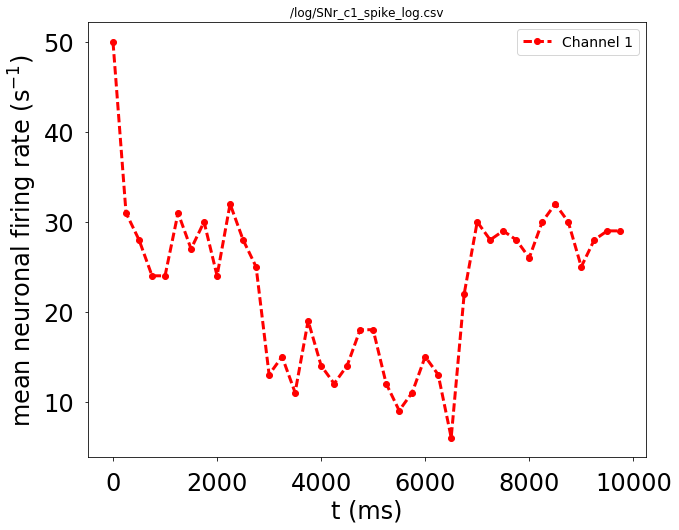

In [31]:
# SNr channel 1 population
bin_edges1, frch1 = vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_3ch_e1','/log/SNr_c1_spike_log.csv', 27, simlength)

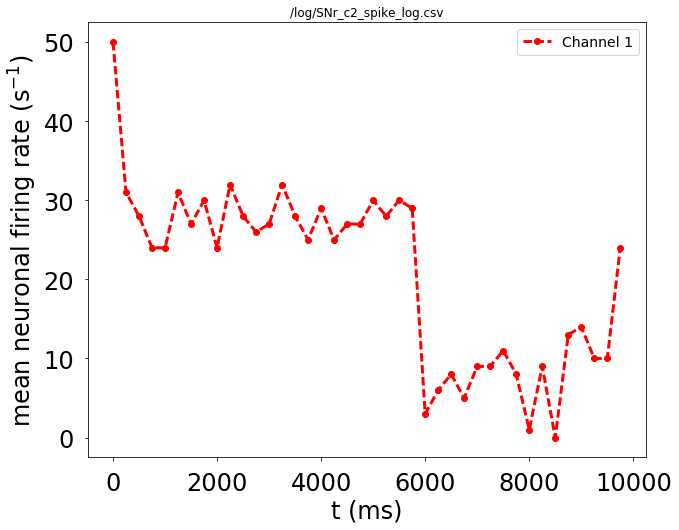

In [32]:
# SNr channel 2 population
bin_edges2, frch2 = vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_3ch_e1','/log/SNr_c2_spike_log.csv', 27, simlength)

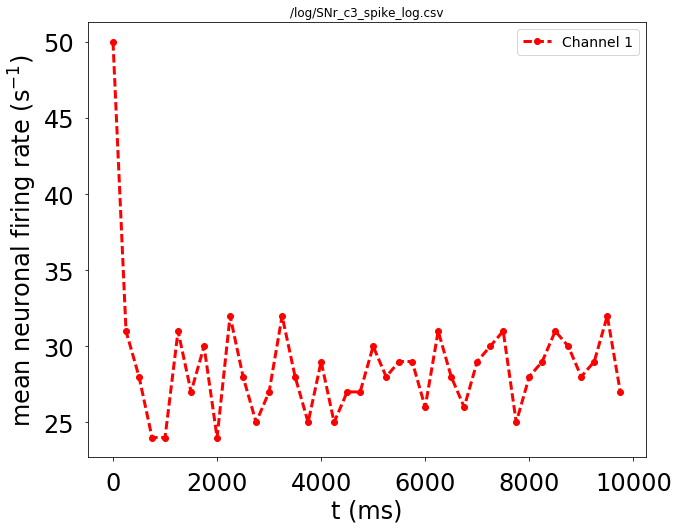

In [33]:
# SNr channel 3 population
bin_edges3, frch3 = vis_data('/home/seb/src/SpineML_2_BRAHMS/temp/Spiking_BG_BSB_3ch_e1','/log/SNr_c3_spike_log.csv', 27, simlength)

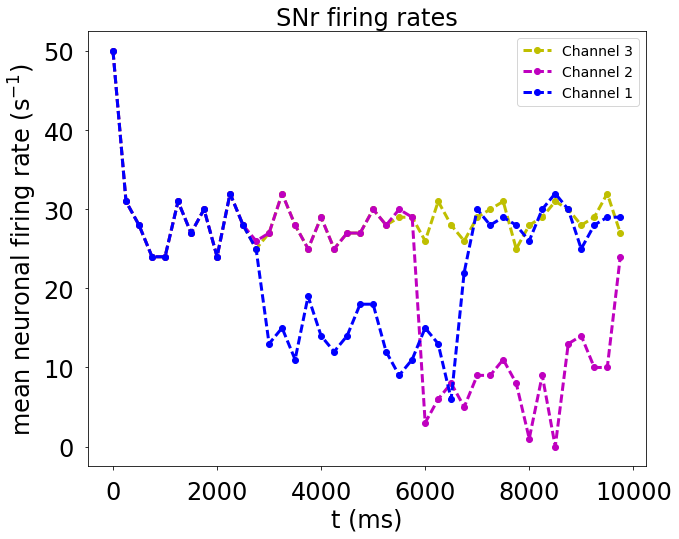

In [34]:
# Graph the results from above

%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

plt.plot (bin_edges2[0:-1],frch3, '--', color='y', marker='o', label='Channel 3', linewidth=3)
plt.plot (bin_edges2[0:-1],frch2, '--', color='m', marker='o', label='Channel 2', linewidth=3)
plt.plot (bin_edges1[0:-1],frch1, '--', color='b', marker='o', label='Channel 1', linewidth=3)

plt.legend(loc='best',fontsize=14)

plt.xlabel('t (ms)',fontsize=24);

from matplotlib import rc
plt.ylabel('mean neuronal firing rate (s$^{-1}$)',fontsize=24);
plt.tick_params(axis='x', labelsize=24, pad=10)
plt.tick_params(axis='y', labelsize=24, pad=10)

plt.title('SNr firing rates', fontsize=24)

graphdir = '/home/seb/models/GPR-BSB/labbook/'

filename = 'bgbsb3_snr'
plt.savefig('{0}{1}.svg'.format(graphdir, filename))

plt.show()

np.savetxt(graphdir+'snr_rates.csv', d1spikes, fmt='%d', delimiter=',', newline='\n')